<h1>DSCI 100 003 - Project Final Report - DANG NGUYEN - 31923584</h1>


# Introduction




## Background
A computer science group at UBC has set up a **Minecraft** server and is recording gameplay sessions to better understand how people interact with video games.  In doing so, they produced two datasets: one holding player information and the other including previous play sessions.  The project's purpose is to use the data produced by the Minecraft server to answer one of the project's lead, **Frank Wood**'s inquiries.

The question I have chosen to focus on is question 1:

> **"What kinds of players are most likely to contribute a large amount of data?" Specifically, I am interested in learning how a player's age might be related to how much data they contribute (i.e. total played hours)."**

I picked this question because I feel it is the most important to the study team.  Understanding which participants offer the most data is crucial for the study team since they require more than just demographic data to answer the group's other two queries.  Essentially, by assessing and selecting the most valuable player group(s) in terms of data contribution, I may assist the study team in identifying individuals who will be useful in answering the remaining questions.


## Data Description
The given data consists of two csv files: 'Players' (7 variables, 196 observations) and 'Sessions' (5 variables, 1535 observations).  Both are summarized here.




### Players

| Variable          | Type of Data*         | Interpretation                                   | Options / Other Notes                                                                 |
|:------------------|:----------------------|:-------------------------------------------------|:-------------------------------------------------------------------------------------|
| experience        | categorial - ordinal  | experience level of player, selected by player   | *Beginner, Amateur, Regular, Pro, Veteran*                                            |
| hashedEmail       | character             | email address of player in hashed form           | e.g. f6daba428a5e19a3d47574858c135...                                                |
| name              | character             | pseudonym chosen by player                       | Many options were provided to players. Given this, it makes sense to treat this as character, not factor. |
| gender            | categorial            | gender of player, selected by the player         | *Male, Female, Non-binary, Agender, Two-Spirited, Other, Prefer not to say*          |
| played_hours      | double                | number of hours player has played on server      | e.g. 22.5                                                                            |
| Age               | double                | age of player, selected by the player            | e.g. 30                                                                              |
| subscribe         | logical               | whether player subscribed to PlaiCraft updates   | *TRUE, FALSE*                                                                        |


* Represents most appropriate type, not the type initially assigned by R.

### Sessions

| Variable             | Type of Data* | Interpretation                        | Other Notes                                      |
|:---------------------|:--------------|:--------------------------------------|:------------------------------------------------|
| hashed_Email         | character     | email address of player in hashed form| e.g. 50499be23603422e6a0ee97...                 |
| start_time           | character     | date, time Plaicraft session began    | e.g. 30/06/2024 18:12                           |
| end_time             | character     | date, time Plaicraft session finished | e.g. 30/06/2024 18:24                           |
| original_start_time  | double        | UNIX timestamp of session start       | e.g. 1.71977E+12                                |
| original_end_time    | double        | UNIX timestamp of session end         | e.g. 1.71977E+12                                |



# Method & Results

## Loading Data
First, I load the necessary libraries, then read the datasets.

In [48]:
library(tidyverse)
library(tidymodels)
library(repr)
library(yardstick)

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Wrangling & Cleaning Data
Then, using the `as_factor` function, I redefine the `experience` and `gender` columns as **factors**, ensuring that these variables are considered as categorical.

In [49]:
players$experience <- as_factor(players$experience)
players$gender <- as_factor(players$gender)

I also use `group_by` to build a new `sessions_sum` data frame, which I then summarize.  This displays me the number of sessions per hashed email, or per individual.

In [50]:
grouped_data <- group_by(sessions, hashedEmail)
sessions_sum <- summarise(grouped_data, number_of_sessions = n())

head(sessions_sum)

hashedEmail,number_of_sessions
<chr>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1


**Table 1. Hashed Email & Number of Sessions** <br>
(Only the head is displayed for the sake of readability.)

Next, I use `merge` to tie this data frame to the `players` data frame.  This pulls together all the necessary factors.  This allows me to use a single data frame for all future analytic stages.

In [51]:
data <- merge(players, sessions_sum, by = "hashedEmail", all.x = TRUE)

head(data)

,hashedEmail,experience,subscribe,played_hours,name,gender,Age,number_of_sessions
,<chr>,<fct>,<lgl>,<dbl>,<chr>,<fct>,<dbl>,<int>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,2
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Veteran,TRUE,0.0,Frankie,Male,17,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Lyra,Male,21,1
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Osiris,Male,17,1
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Winslow,Male,17,13
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Pro,TRUE,1.0,Knox,Male,17,2


**Table 2. Dataframe of all player variables** <br>
(Only the head is displayed for the sake of readability.)

## Data Analysis 1 - Linear Regression
I begin my data analysis by setting the seed.  The data was then divided into two sets: training and testing, using a 70:30 ratio.

In [52]:
set.seed(1000) 

data_split <- initial_split(data, prop = 0.7, strata = Age)
data_training <- training(data_split)
data_testing <- testing(data_split)

### Summary of Dataset Relevant For Exploratory Data Analysis
Here, I provide a brief overview of the data relevant to my exploratory data analysis (i.e., 'Age'), calculating the mean, maximum and lowest age values, and standard deviation.

In [53]:
summary <- data.frame(
  mean = with(data_training, mean(Age)),
  median = with(data_training, median(Age)),
  max = with(data_training, max(Age)),
  min = with(data_training, min(Age)),
  standard_deviation = with(data_training, sd(Age))
)

summary

mean,median,max,min,standard_deviation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.74627,19,50,8,6.29439


The training data shows that the minimum age is 8 years and the maximum age is 50 years.  The average age is 20.7 years, with a median age of 19.

Before I build a model, I create a **scatterplot** with `ggplot` to examine if there appears to be an association between the `Age` and `played_hours` variables.

#### **Figure 1. Total Playtime vs. Age**

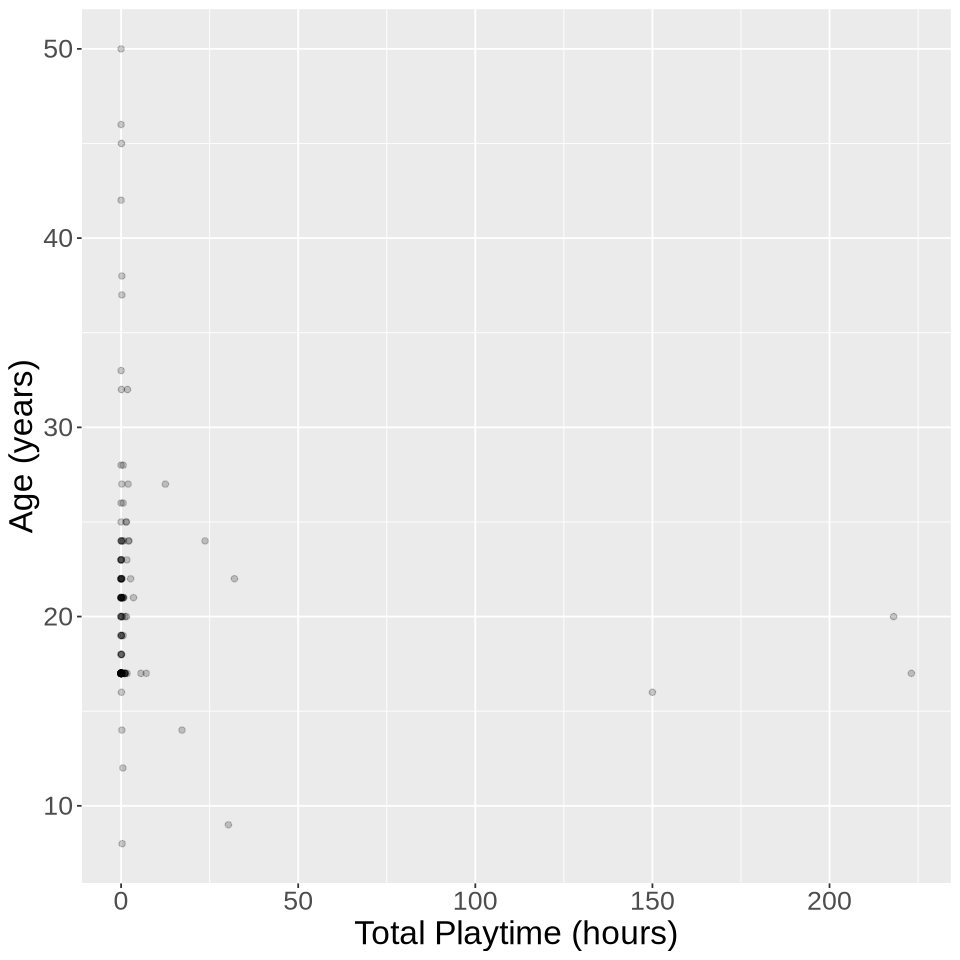

In [54]:
options(repr.plot.width = 8, repr.plot.height = 8)

age_playtime <- data_training %>%
ggplot(aes(x = played_hours, y = Age)) +
geom_point(alpha = 0.2) +
xlab("Total Playtime (hours)") +
ylab("Age (years)") +
theme(text = element_text(size = 20))

age_playtime

This figure indicates that the training dataset primarily consists of young players (<25 years old) with minimal or no playing time.  All players that play for more than 25 hours are under 25 years old.

Figure 1 shows that the connection between 'Age' and 'played_hours' is not very evident, although it may be flat or weakly linear.  There appear to be many outliers, with the bulk of participants having played 0 hours.

I would want to look at the link between Age and played_hours.  Because both variables are numerical and there is a hint of a linear relationship, I will attempt a linear regression.  Because I want to know the features of players that provide a substantial quantity of data, I will build a model that predicts Age based on played_hours.  If my model is correct (i.e., if the **RMSE** and **RMSPE** are low enough), I will infer that a player's age can help me estimate their *played hours*.

In this step, I will:

* create a linear regression model specification, named lm_spec
* create a recipe for lm_spec, named data_recipe
* fit the model specification and recipe in a workflow, named data_fit

In [62]:
lm_spec <- linear_reg() %>%
       set_engine("lm") %>%
       set_mode("regression")

data_recipe <- recipe(Age ~ played_hours, data = data_training)

data_fit <- workflow() %>%
       add_recipe(data_recipe) %>%
       add_model(lm_spec) %>%
       fit(data = data_training)

data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  played_hours  
    20.84164      -0.01682  



The equation of the line shows that for played_hours = 0, the anticipated age is 20.84 (y-intercept).  The slope is about zero.  Because most gamers play for zero hours, the intercept is near to the average player age.

Next, I'll compute the **RMSE** and **RMSPE** with **data_training** to determine the goodness of fit for `data_fit`. This will tell me how well the model predicts the training data used to fit it.

In [88]:
rmse_training <- data_training %>%
  bind_cols(predict(data_fit, new_data = data_training)) %>%
  rmse(truth = Age, estimate = .pred) %>%
  pull(.estimate)

rmspe_training <- data_training %>%
  bind_cols(predict(data_fit, new_data = data_training)) %>%
  mutate(percentage_error = ((Age - .pred) / Age)^2) %>%
  summarise(rmspe = sqrt(mean(percentage_error, na.rm = TRUE))) %>%
  pull(rmspe)

print(rmse_training)
print(rmspe_training)

[1] 6.250865
[1] 0.2830374


The **RMSE** and **RMSPE** with **training_data** tells me that the training data points on the scatterplot were off by ~6.25 years from the line of best fit and my model has ~28.3% average percentage error.

Given that the sample largely comprises of players < 25 years, a 6-year discrepancy in anticipated age is significant.  Using `played_hours` as a predictor produces an inaccurate forecast.

The outliers (points of startlingly long play periods and points of unusually advanced age) may contribute to this.  I identify them by arranging the data frame in **descending order** for each variable using the `arrange` function.

#### **Table 3. All Players, in descending order of `age`**

In [64]:
age_desc <- arrange(data, desc(Age))
head(age_desc)

,hashedEmail,experience,subscribe,played_hours,name,gender,Age,number_of_sessions
,<chr>,<fct>,<lgl>,<dbl>,<chr>,<fct>,<dbl>,<int>
1,7b17513f11968feaf6b02977885c436dc2a4549489ca25ef03022f9fbae19d81,Regular,FALSE,0.0,Balthazar,Male,50,1
2,c57fa94e436cf49a929d0168e47d26fec3d900b321775e280ef136979c01d5a4,Regular,TRUE,18.5,Dante,Male,49,16
3,4c0662a559f9d83b4d84ce3d86e6577c9f7a426c80465c6174321afd96664da5,Veteran,FALSE,0.0,Selena,Male,46,NA
4,6fa105fac7f4f37350f21830db78cde153d8edda41d6f4f2d48c9785d605c5e5,Amateur,FALSE,0.1,Yosef,Male,45,1
5,ba24bebe588a34ac546f8559850c65bc90cd9d51b821581bd6e25cff437a1081,Veteran,TRUE,0.1,Gabriela,Female,44,1
6,5e5c25a773be7a62638a163d773534e575a5ad5782104723e53cb676a30fa60b,Beginner,FALSE,0.0,Jude,Female,42,NA


(Only the head is displayed for the sake of readability.)

#### **Table 4. All Players, in descending order of `played_hours`**

In [65]:
playtime_desc <- arrange(data, desc(played_hours))
head(playtime_desc)

,hashedEmail,experience,subscribe,played_hours,name,gender,Age,number_of_sessions
,<chr>,<fct>,<lgl>,<dbl>,<chr>,<fct>,<dbl>,<int>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,Regular,TRUE,223.1,Hiroshi,Male,17,219
2,b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,Regular,TRUE,218.1,Akio,Non-binary,20,95
3,ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,Regular,TRUE,178.2,Piper,Female,19,147
4,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,Amateur,TRUE,150.0,Delara,Female,16,159
5,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,Amateur,TRUE,56.1,Dana,Male,23,310
6,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,Amateur,TRUE,53.9,Alex,Male,17,130


(Only the head is displayed for the sake of readability.)

I can see that players **Balthazar, Dante, Selena, Yosef, Gabriela, Jude, Hiroshi, Akio, Piper, and Delara** have either: (1) playtimes that are orders of magnitude higher than most of the players, or (2) a significantly advanced age when compared to most other players.

I believe outliers of type (1) may be research team members testing the server.  I only want to incorporate participant data.  I believe outliers of type (2) are produced by gamers submitting an incorrect age or just having a lot more spare time than ordinary persons at their ages.  These outliers might be influencing our model's accuracy.

I use `filter` function to remove types (1) and (2) from the data frame.

#### **Table 5. Dataframe of all player data, with outliers removed**

In [66]:
outliers <- c('Balthazar', 'Dante', 'Selena', 'Yosef', 'Gabriela', 'Jude', 'Hiroshi', 'Akio', 'Piper', 'Delara')

revised_data <- filter(data, !name %in% outliers)

head(revised_data)

,hashedEmail,experience,subscribe,played_hours,name,gender,Age,number_of_sessions
,<chr>,<fct>,<lgl>,<dbl>,<chr>,<fct>,<dbl>,<int>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Isaac,Male,20,2
2,055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f,Veteran,TRUE,0.0,Frankie,Male,17,NA
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Lyra,Male,21,1
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Osiris,Male,17,1
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Winslow,Male,17,13
6,0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Pro,TRUE,1.0,Knox,Male,17,2


Using this revised data frame, I'll now repeat the whole procedure (except for constructing the recipe, which is identical) and compute the **RMSE** and **RMSPE**.

In [67]:
set.seed(1000)

revised_data_split <- initial_split(revised_data, prop = 0.7, strata = Age)
revised_data_training <- training(revised_data_split)
revised_data_testing <- testing(revised_data_split)

revised_data_recipe <- recipe(Age ~ played_hours, data = revised_data_training)

revised_data_fit <- workflow() |>
       add_recipe(revised_data_recipe) |>
       add_model(lm_spec) |>
       fit(data = revised_data_training)

revised_data_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
 (Intercept)  played_hours  
    19.95875      -0.08645  


In [86]:
revised_rmse_training <- revised_data_training %>%
  bind_cols(predict(revised_data_fit, new_data = revised_data_training)) %>%
  rmse(truth = Age, estimate = .pred) %>%
  pull(.estimate)

revised_rmspe_training <- revised_data_training %>%
  bind_cols(predict(revised_data_fit, new_data = revised_data_training)) %>%
  mutate(percentage_error = ((Age - .pred) / Age)^2) %>%
  summarise(rmspe = sqrt(mean(percentage_error, na.rm = TRUE))) %>%
  pull(rmspe)

print(revised_rmse_training)
print(revised_rmspe_training)

[1] 3.946607
[1] 0.1887416


The revised **RMSE** and **RMSPE** values are both lower than the previous values computed with outliers.  The **RMSE** of 3.94 is far more accurate than the previous estimate of ~6.25 years.  The model has a reasonable **RMSPE** value of 18.87%, which is generally acceptable.

### Visualization of Linear Regression
Finally, I visualize the linear model I developed, notably the one without outliers.

#### **Figure 2. Total Playtime vs Player Age**

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


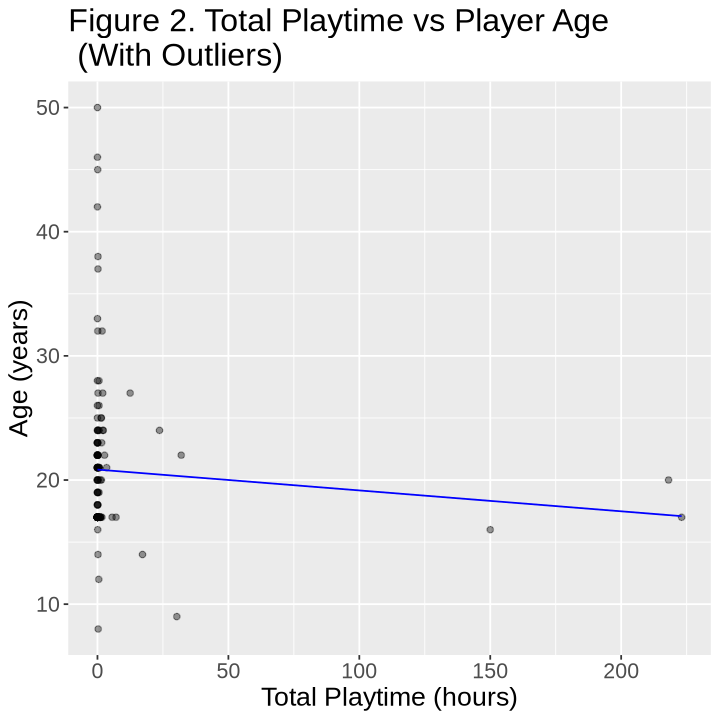

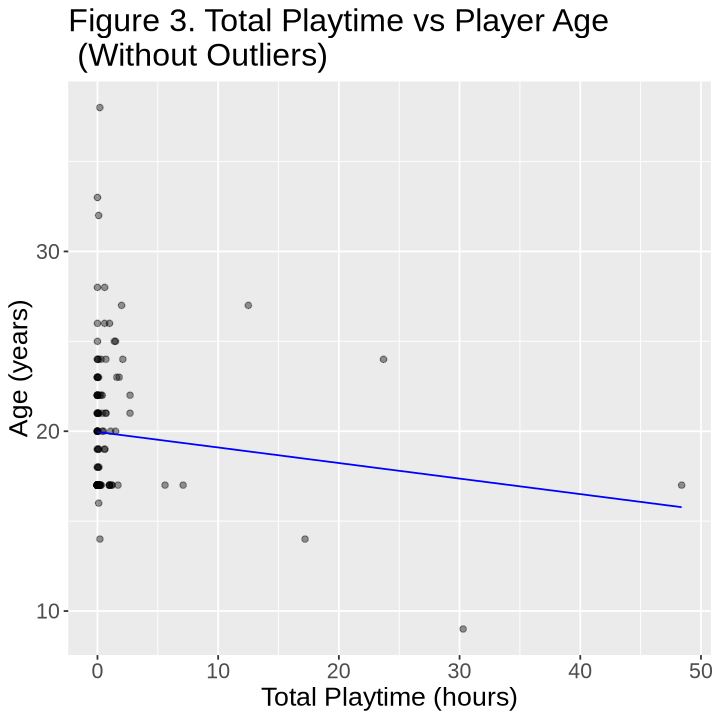

In [68]:
options(repr.plot.width = 6, repr.plot.height = 6)

# With Outliers
lm_preds_1 <- data_fit |>
  predict(data_training) |>
  bind_cols(data_training)

lm_predictions_1 <- lm_preds_1 |>
	ggplot(aes(x = played_hours, y = Age)) +
    	geom_point(alpha = 0.4) +
    	geom_line(
        	mapping = aes(x = played_hours, y = .pred),
        	color = "blue") +
    	xlab("Total Playtime (hours)") +
        ylab("Age (years)") +
    	theme(text = element_text(size = 16)) +
    	ggtitle("Figure 2. Total Playtime vs Player Age \n (With Outliers)")

# Without Outliers
lm_preds_2 <- revised_data_fit |>
  predict(revised_data_training) |>
  bind_cols(revised_data_training)

lm_predictions_2 <- lm_preds_2 |>
	ggplot(aes(x = played_hours, y = Age)) +
    	geom_point(alpha = 0.4) +
    	geom_line(
        	mapping = aes(x = played_hours, y = .pred),
        	color = "blue") +
    	xlab("Total Playtime (hours)") +
        ylab("Age (years)") +
    	theme(text = element_text(size = 16)) +
    	ggtitle("Figure 3. Total Playtime vs Player Age \n (Without Outliers)")

lm_predictions_1
lm_predictions_2

The model with outliers eliminated outperformed the model with outliers.  However, other variables may be stronger predictors.

It's possible that `Age` and `played_hours` have a stronger relationship, but it isn't linear.  In my next analysis, knn-regression, I will investigate this option.

## Data Analysis 2 - KNN Regression
Instead of using linear regression, I may create a knn-regression model.  Re-examining figure 1, the connection does not appear to be very linear; the data's characteristics may suggest that a non-linear model is a better fit.

We can use knn regression to predict `Age` based on `total_played_hours`.

To begin, I'll need to do 5-fold cross validation on the training dataset to get the best k. I will use the data without the outliers.

In [73]:
data_model_knn <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") %>%
  set_mode("regression") %>%
  set_engine("kknn")

recipe_knn <- recipe(Age ~ played_hours, data = revised_data_training) %>%
  step_center(all_predictors()) %>%
  step_scale(all_predictors())

folds <- vfold_cv(data, v = 5, strata = Age)

workflow_knn <- workflow() %>%
  add_model(data_model_knn) %>%
  add_recipe(recipe_knn)

k_values <- tibble(neighbors = 1:10)

tuning_results <- workflow_knn %>%
  tune_grid(
    resamples = folds,
    grid = k_values
  ) %>%
  collect_metrics()

head(tuning_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,7.51980875,5,0.53567652,Preprocessor1_Model01
1,rsq,standard,0.05139263,5,0.03608594,Preprocessor1_Model01
2,rmse,standard,6.82479480,5,0.41646930,Preprocessor1_Model02
2,rsq,standard,0.02672265,5,0.01436328,Preprocessor1_Model02
3,rmse,standard,6.73006674,5,0.41926061,Preprocessor1_Model03
3,rsq,standard,0.02913138,5,0.01117737,Preprocessor1_Model03


The optimal k will have the lowest **RMSE** value. Thus, I look for the k value that results in the **minimum RMSE**.

In [75]:
best_result <- data_results %>%
  filter(.metric == "rmse") %>%
  arrange(mean) %>%
  slice(1)

k_min <- best_result %>%
  pull(neighbors)

k_min

[1] 10

Now, I can train my final model using this k value.

In [95]:
final_knn_spec <- nearest_neighbor(neighbors = 10, weight_func = "rectangular") %>%
  set_mode("regression") %>%
  set_engine("kknn")

final_knn_model <- workflow() %>%
  add_model(final_knn_spec) %>%
  add_recipe(revised_data_recipe) %>%
  fit(data = revised_data_training)

Next, I test the model's efficacy using the metrics function.

In [96]:
data_summary <- data_best_fit |> 
                       predict(revised_data_training) |>
                       bind_cols(revised_data_training) |>
                       metrics(truth = Age, estimate = .pred)
data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.27513111
rsq,standard,0.04586744
mae,standard,2.79920635


The **RMSE** is approximately 4.27. This means the average difference between a data point and my line of best fit is 4.27 years.

Out of my expectation, this model's performance on predicating `Age` based on `played_hours` is worse than the linear model.

### Visualization of KNN Regression
Finally, I visualize the model I have created.

#### **Figure 4. Total Playtime vs Player Age (KNN Regression without outliers)**

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


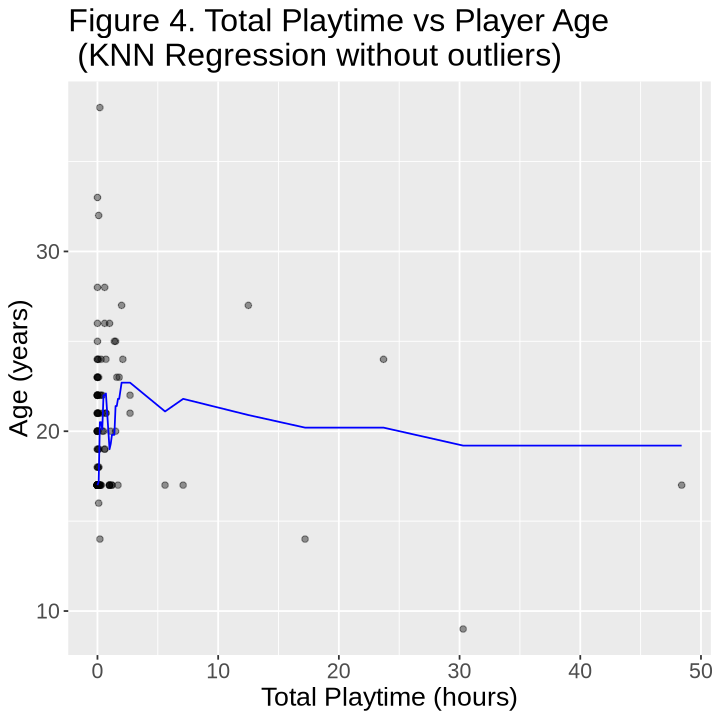

In [97]:
options(repr.plot.width = 6, repr.plot.height = 6)

ref_data_preds <- data_best_fit |>
  predict(revised_data_training) |>
  bind_cols(revised_data_training)

knn_predictions <- ref_data_preds |>
	ggplot(aes(x = played_hours, y = Age)) +
    	geom_point(alpha = 0.4) +
    	geom_line(
        	mapping = aes(x = played_hours, y = .pred),
        	color = "blue") +
    	xlab("Total Playtime (hours)") +
        ylab("Age (years)") +
    	theme(text = element_text(size = 16)) +
    	ggtitle("Figure 4. Total Playtime vs Player Age \n (KNN Regression without outliers)")

knn_predictions

I notice significant overfitting in this part of the model, particularly for lesser amounts of played hours.  This shows that my k value is too low.  However, a greater k leads to a higher **RMSE**, as calculated above.  This paradox is most likely caused by the vast number of points at or near zero, as well as the relative scarcity of data points across a bigger number of played hours!

# Discussion


## Summary
In my exploratory data analysis, I plotted `Age` versus `Played_hours` (Figure 1).  Based on my exploratory study, I predicted a linear relationship between the player's age and the overall number of hours played.  I built a linear regression model in which the predictor variable was the total number of hours played (played_hours) and the predicted variable was the player's age (Age).

To evaluate the model's performance, I used the training model to estimate age from test data and computed the RMSE.  With outliers, the model had a RMSE of 6.25, but without them, it was 3.94.  My findings indicate that there is a weak to moderately negative linear association between age and total played hours.  **Figure 1 shows that gamers under the age of 25 contribute the greatest playtime.**

When a linear model did not produce a very good RMSE, I examined the exploratory plot and recognized the relationship might not be linear.  I subsequently built a knn regression model, which had a similarly morderate RMSE of 4.27.

**I conclude that both models are moderately effective, especially when eliminating the outliers**.

## Expectations and Limitations

My expectations were somewhat met by the outcomes. I didn't anticipate a very well-fitting model or a low RMSPE because the linear relationship looked weak and flat in the exploratory analysis.

Early on in the project, I was worried about the size of the dataset, especially since a significant percentage of users (85/196) provided zero hours of gameplay.  I could make better predictions with a dataset that was more representative of a variety of played hours!  These 0 hour points are probably what drove the association I saw, producing model slopes that are almost flat and erasing any other patterns I could have noticed.

## Potential Impact
Targeted marketing and recruitment efforts can benefit from knowing the demographic information of the people who provide the most playtime.

In this instance, the study team can concentrate their attention on younger gamers (those under 25), as I think they may contribute the greatest playtime.  For instance, the researchers might promote their study in places that young adults visit, such as social media, relevant subreddits, colleges, universities, and high schools.

Additionally, the researchers might concentrate their efforts on improving younger players' interest.  For instance, social or competitive aspects may be very enticing to this group.

## Future Question
My research leads me to a number of areas for further study.  My question is "Can I use played_hours to more accurately predict other demographic characteristics of players?"

Investigating subscription status and its connection to played hours seems interesting.  Based on my own projects' exploratory visualizations, I discovered that nearly every player with a high level of played_hours receives Plaicraft email updates.  Subscription status might be used to forecast the amount of hours played in future research.

Additionally, I anticipate that investigating experience level and its connection to played_hours may be intriguing.  According to my own exploratory data studies, frequent and amateur players have more played hours than players with other expertise levels.